In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os



In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
import pandas as pd

# Create a list to store the text files
texts=[]

# open file zkBridge.md
with open("text/zkBridge.md", "r") as f:
    text = f.read()
    texts.append(("ZK Crosschain Communication Protocol Analysis author glaze", text))

# # Get all the text files in the text directory
# for file in os.listdir("text/" + domain + "/"):

#     # Open the file and read the text
#     with open("text/" + domain + "/" + file, "r") as f:
#         text = f.read()

#         # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
#         texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))
#         print((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update','')))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/var/folders/3h/x2vwrgdn3q7377nzz8cqf8pw0000gn/T/ipykernel_30342/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,ZK Crosschain Communication Protocol Analysis ...,ZK Crosschain Communication Protocol Analysis ...


<AxesSubplot: >

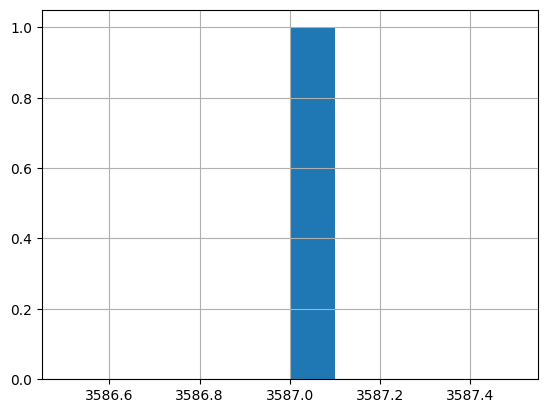

In [4]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [17]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

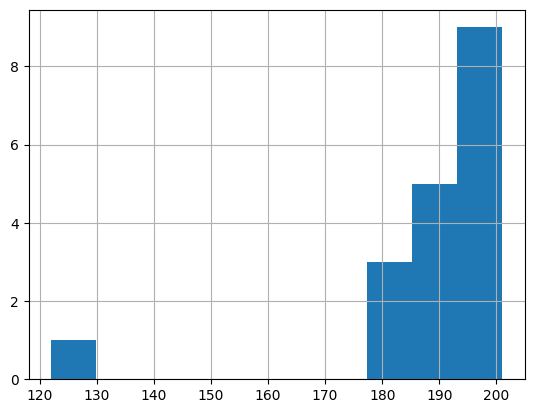

In [18]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [19]:
import openai
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,ZK Crosschain Communication Protocol Analysis ...,194,"[0.0144326938316226, -0.0037549014668911695, 0..."
1,Builders move from Ethereum to ALT to fork exi...,179,"[0.011696076951920986, -0.02797858603298664, -..."
2,"Again, it is sometimes stuck and vulnerable, b...",191,"[-0.010517262853682041, 0.0033294293098151684,..."
3,There are several cross-chain bridges availabl...,180,"[0.014372102916240692, -0.010157470591366291, ..."
4,The use of succinct proofs in the ZK bridge no...,195,"[0.02146933041512966, -0.023072121664881706, -..."


In [20]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [21]:
from openai.embeddings_utils import distances_from_embeddings

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,ZK Crosschain Communication Protocol Analysis ...,194,"[0.0144326938316226, -0.0037549014668911695, 0..."
1,Builders move from Ethereum to ALT to fork exi...,179,"[0.011696076951920986, -0.02797858603298664, -..."
2,"Again, it is sometimes stuck and vulnerable, b...",191,"[-0.010559254325926304, 0.0033693495206534863,..."
3,There are several cross-chain bridges availabl...,180,"[0.014372102916240692, -0.010157470591366291, ..."
4,The use of succinct proofs in the ZK bridge no...,195,"[0.02146933041512966, -0.023072121664881706, -..."


In [22]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,ZK Crosschain Communication Protocol Analysis ...,194,"[0.0144326938316226, -0.0037549014668911695, 0..."
1,Builders move from Ethereum to ALT to fork exi...,179,"[0.011696076951920986, -0.02797858603298664, -..."
2,"Again, it is sometimes stuck and vulnerable, b...",191,"[-0.010559254325926304, 0.0033693495206534863,..."
3,There are several cross-chain bridges availabl...,180,"[0.014372102916240692, -0.010157470591366291, ..."
4,The use of succinct proofs in the ZK bridge no...,195,"[0.02146933041512966, -0.023072121664881706, -..."


In [23]:
def create_context(
    question, df, max_len=3800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [27]:
answer_question(df, question="Explain zkbridge project", debug=False)


'zkBridge is a project that uses succinct proofs in the ZK bridge to guarantee the successful completion of cross-chain transfers. It also significantly reduces the cost of on-chain verification, ensuring that users can safely and efficiently transfer assets between different blockchain networks without worrying about the security of their transactions. The project uses zkSNARKs, MPC, and light clients to generate and relay the ZKP of block headers to the target chains, and uses deVrigo and recursive proof to achieve very fast proof times.'

In [25]:
answer_question(df, question="Summarize the passage ZK Crosschain Communication Protocol Analysis" ,debug=False)

'ZK Crosschain Communication Protocol Analysis discusses the use of ZK technology for cross-chain communication protocols to improve security and reduce the risk of attacks. It outlines the workflow of the ZK bridge, including storage proof generation, design architecture, and application scenarios. It also compares different methods of relaying ZKP and introduces related projects such as Succinct Labs, Lagrange, zkBridge, and Herodotus. Finally, it highlights the importance of latency and cost as major benchmarks for different projects.'

In [26]:
answer_question(df, question="What is the future application of cross-chain communication protocol" ,debug=False)

'The future application of cross-chain communication protocol is expected to be significant in the coming years, akin to the impact of globalization. It can be used for DeFi, DID, and governance, as well as asset bridges, money management, and on-chain derivatives.'